# CS 328 Narrative Writing

This is our submission for the writing assignment for **CS 328: Introduction to Data Science**.
Our team members are:
- **Jiya Desai**: 22110107
- **Viraj Vekaria**: 22110287
- **Sujal Patel** : 22110261

### About the Dataset

This is an exploratory study done on the world inequality dataset provided on https://wid.world .

The dataset itself provided a wealth of information about several financial and inequality indicators for different countries and regions. Some key indicators include:
- **GDP per capita**: A measure of a country's economic output that accounts for its number of people.
- **Gini index**: A measure of income inequality within a population, ranging from 0 (perfect equality) to 1 (perfect inequality).
- **Net national income**: The total income of a country's residents, including wages, profits, rents, and taxes, minus subsidies.
- **Net Wealth**: The total value of a country's assets, including real estate and financial assets, minus liabilities.
- **Top 1% share**: The share of total income or wealth held by the top 1% of the population.
- **Top 10% share**: The share of total income or wealth held by the top 10% of the population.
- **Bottom 50% share**: The share of total income or wealth held by the bottom 50% of the population.

---

## Setup

### Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import os
from tqdm import tqdm
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from plotly.subplots import make_subplots
import matplotlib as mpl
from linearmodels.panel import PanelOLS, RandomEffects, compare
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')


# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create output directories if they don't exist
os.makedirs('figures', exist_ok=True)
os.makedirs('output', exist_ok=True)

### Data

In [46]:
# File paths
file_income = "WID_data/WID_Data_Average_National_Income.csv"
file_national_income = "WID_data/WID_Data_National_Income.csv"
file_net_personal_wealth = "WID_data/WID_Data_Net_Personal_Wealth.csv"
file_wealth_inequality = "WID_data/WID_Data_Wealth_Gini_Coeff.csv"
file_income_inequality = "WID_data/WID_Data_Income_Gini_Coeff.csv"
file_wealth_to_income = "WID_data/WID_Data_Net_National_Wealth_To_Net_National_Income_Ratio.csv"
file_GDP = "WID_data/WID_Data_GDP.csv"
file_population = "WID_data/WID_Data_Population.csv"

# Read the datasets
df_income_wealth = pd.read_csv(file_income, header=1, sep=';')
df_wealth_inequality = pd.read_csv(file_wealth_inequality, header=1, sep=';')
df_income_inequality = pd.read_csv(file_income_inequality, header=1, sep=';')
df_wealth_to_income = pd.read_csv(file_wealth_to_income, header=1, sep=';')
df_GDP = pd.read_csv(file_GDP, header=1, sep=';')
df_population = pd.read_csv(file_population, header=1, sep=';')
df_net_wealth = pd.read_csv(file_net_personal_wealth, header=1, sep=';')
df_national_income = pd.read_csv(file_national_income, header=1, sep=';')

In [47]:
# df_national_income

In [48]:

# Define a reshaping function
def reshape_wid(df, value_column_name):
    df_long = df.melt(id_vars=['Percentile', 'Year'], var_name='Country', value_name=value_column_name)
    df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
    df_long['Country'] = df_long['Country'].str.strip()
    
    # Prefer 'pall', else take 'p90p100'
    if 'pall' in df_long['Percentile'].unique():
        df_long = df_long[df_long['Percentile'] == 'pall']
    else:
        df_long = df_long[df_long['Percentile'] == 'p90p100']
        
    return df_long.drop(columns=['Percentile'])

# Reshape and clean all datasets
df_income_long = reshape_wid(df_income_wealth, 'PerAdultIncome')
df_wealth_ineq_long = reshape_wid(df_wealth_inequality, 'WealthInequality')
df_income_ineq_long = reshape_wid(df_income_inequality, 'IncomeInequality')
df_wealth_to_income_long = reshape_wid(df_wealth_to_income, 'WealthToIncomeRatio')
df_GDP_long = reshape_wid(df_GDP, 'GDP')
df_population_long = reshape_wid(df_population, 'Population')
df_net_wealth_long = reshape_wid(df_net_wealth, 'NetPersonalWealth')
df_national_income_long = reshape_wid(df_national_income, 'NationalIncome')

# Merge all datasets on ['Country', 'Year']
dfs_to_merge = [
    df_income_long,
    df_wealth_ineq_long,
    df_income_ineq_long,
    df_wealth_to_income_long,
    df_GDP_long,
    df_population_long,
    df_net_wealth_long,
    df_national_income_long
]

from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='inner'), dfs_to_merge)

# Final diagnostic
print("Merged DataFrame:")
print(df_merged.head())
print("Shape:", df_merged.shape)
print("Columns:", df_merged.columns.tolist())
df_merged.to_csv("merged_dataset.csv", index=False)

Merged DataFrame:
   Year    Country  PerAdultIncome  WealthInequality  IncomeInequality  WealthToIncomeRatio        GDP  Population  NetPersonalWealth  NationalIncome
0  1995  Argentina      32274.1540            0.6419            0.6419             3.355870  3246941.8    35070020             0.6186      21577.3592
1  1996  Argentina      33500.0116            0.6419            0.6419             3.358287  3383565.3    35513793             0.6186      22396.9085
2  1997  Argentina      35821.4993            0.6419            0.6419             3.330600  3613854.8    35947791             0.6186      23948.7617
3  1998  Argentina      36560.4663            0.6419            0.6419             3.415269  3709134.5    36372860             0.6187      24442.7282
4  1999  Argentina      34567.7028            0.6419            0.6419             3.471241  3542473.8    36794682             0.6186      23110.5914
Shape: (1479, 10)
Columns: ['Year', 'Country', 'PerAdultIncome', 'WealthInequality

---

## Introduction

In [49]:
df_merged[df_merged['Year'] == 2020]

,Year,Country,PerAdultIncome,WealthInequality,IncomeInequality,WealthToIncomeRatio,GDP,Population,NetPersonalWealth,NationalIncome
25,2020,Argentina,32289.7654,0.6001,0.6001,3.699519,3.723786e+06,45191965,0.6017,21588.5889
54,2020,Australia,71637.5304,0.4824,0.4824,7.473608,9.237230e+04,25743791,0.5785,48091.7941
83,2020,Austria,68307.5019,0.4186,0.4186,5.840621,4.968150e+04,8921405,0.6147,45660.0813
112,2020,Bangladesh,12258.3124,0.4973,0.4973,6.242529,2.332324e+05,166298024,0.5904,8194.2649
141,2020,Belgium,67777.7606,0.4322,0.4322,6.842180,4.520550e+04,11540107,0.5215,45305.9756
170,2020,Brazil,22306.5472,0.7018,0.7018,4.047745,4.603440e+04,208660842,0.6996,14912.9341
199,2020,Canada,65652.4257,0.4967,0.4967,6.631920,6.833220e+04,38171902,0.5830,43873.6994
228,2020,Chile,30639.5685,0.7164,0.7164,4.985224,1.262478e+07,19370624,0.6975,20481.6411
257,2020,China,22380.6966,0.5602,0.5602,9.391389,7.629590e+04,1426106093,0.6778,14740.7406
286,2020,Colombia,21945.7072,0.7341,0.7341,3.738157,2.582326e+07,50629997,0.7053,14671.1006


## Hypothesis 1

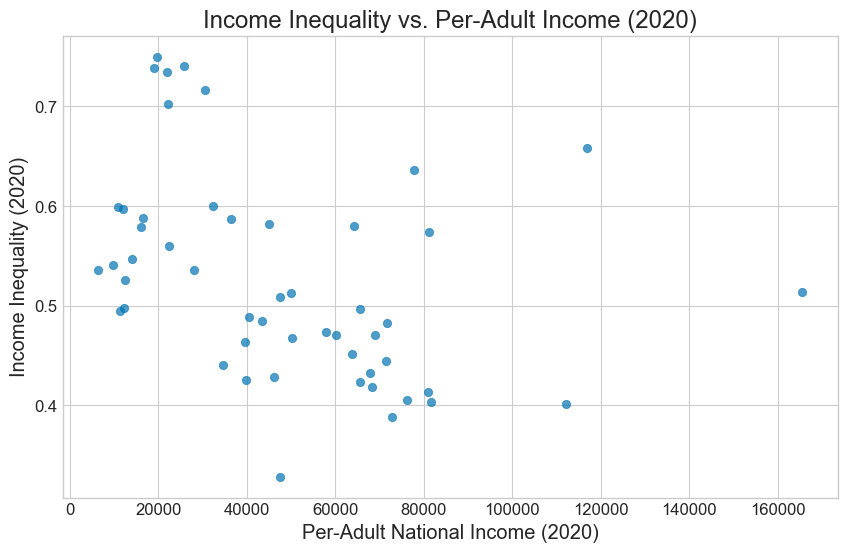

Correlation between Per-Adult Income and Income Inequality: -0.3732727378845258
                            OLS Regression Results                            
Dep. Variable:       IncomeInequality   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     7.933
Date:                Wed, 23 Apr 2025   Prob (F-statistic):            0.00698
Time:                        18:15:16   Log-Likelihood:                 48.002
No. Observations:                  51   AIC:                            -92.00
Df Residuals:                      49   BIC:                            -88.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

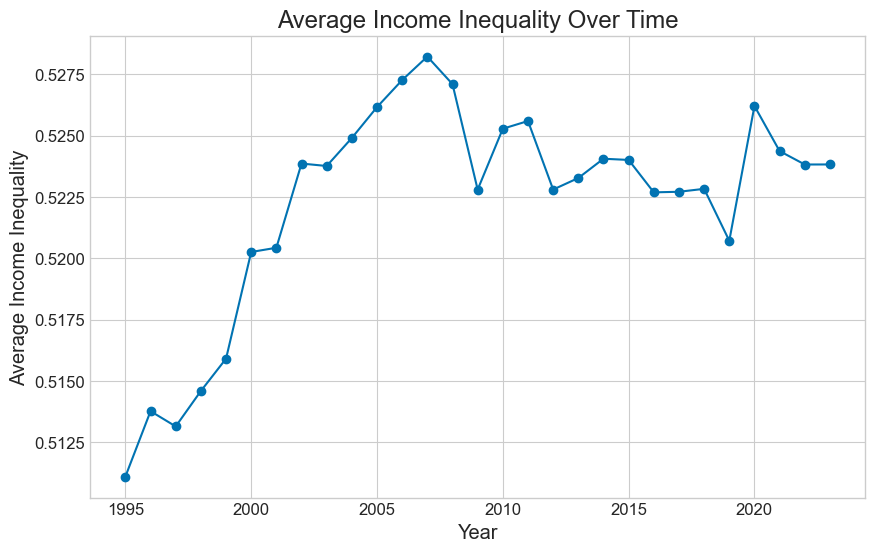

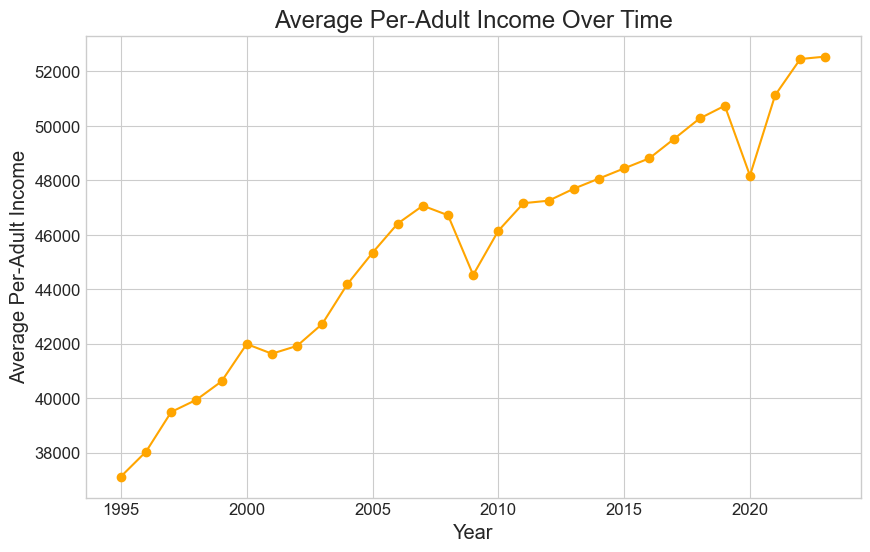

In [50]:
# 1. Scatter plot for Income Inequality vs Per-Adult Income for 2020
df_2020 = df_merged[df_merged['Year'] == 2020].copy()
plt.figure(figsize=(10, 6))
plt.scatter(df_2020['PerAdultIncome'], df_2020['IncomeInequality'], alpha=0.7)
plt.xlabel("Per-Adult National Income (2020)")
plt.ylabel("Income Inequality (2020)")
plt.title("Income Inequality vs. Per-Adult Income (2020)")
plt.grid(True)
plt.show()

# 2. Calculate Pearson correlation
corr_h1 = df_2020['PerAdultIncome'].corr(df_2020['IncomeInequality'])
print("Correlation between Per-Adult Income and Income Inequality:", corr_h1)

# 3. Regression model
X = sm.add_constant(df_2020['PerAdultIncome'])
model_h1 = sm.OLS(df_2020['IncomeInequality'], X).fit()
print(model_h1.summary())

# 4. Average Income Inequality over time
avg_inequality = df_merged.groupby("Year")["IncomeInequality"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_inequality.index, avg_inequality.values, marker='o')
plt.xlabel("Year")
plt.ylabel("Average Income Inequality")
plt.title("Average Income Inequality Over Time")
plt.grid(True)
plt.show()


# 5. Average Per-Adult Income over time
avg_income = df_merged.groupby("Year")["PerAdultIncome"].mean()
df_merged

plt.figure(figsize=(10, 6))
plt.plot(avg_income.index, avg_income.values, marker='o', color='orange')
plt.xlabel("Year")
plt.ylabel("Average Per-Adult Income")
plt.title("Average Per-Adult Income Over Time")
plt.grid(True)
plt.show()


In [51]:

# 5. Average Per-Adult Income over time
avg_income = df_merged.groupby("Year")["PerAdultIncome"].mean()
df_merged

,Year,Country,PerAdultIncome,WealthInequality,IncomeInequality,WealthToIncomeRatio,GDP,Population,NetPersonalWealth,NationalIncome
0,1995,Argentina,32274.1540,0.6419,0.6419,3.355870,3246941.8,35070020,0.6186,21577.3592
1,1996,Argentina,33500.0116,0.6419,0.6419,3.358287,3383565.3,35513793,0.6186,22396.9085
2,1997,Argentina,35821.4993,0.6419,0.6419,3.330600,3613854.8,35947791,0.6186,23948.7617
3,1998,Argentina,36560.4663,0.6419,0.6419,3.415269,3709134.5,36372860,0.6187,24442.7282
4,1999,Argentina,34567.7028,0.6419,0.6419,3.471241,3542473.8,36794682,0.6186,23110.5914
...,...,...,...,...,...,...,...,...,...,...
1474,2019,Korea,51641.4433,0.4682,0.4682,8.460069,40137444.0,51767846,0.6632,34569.1831
1475,2020,Korea,50219.4959,0.4671,0.4671,9.162324,39783028.0,51858482,0.6608,33617.3205
1476,2021,Korea,52411.9516,0.4445,0.4445,9.351987,41503652.0,51848397,0.6622,35084.9640
1477,2022,Korea,54071.5597,0.4445,0.4445,9.678047,42642276.0,51782512,0.6610,36198.4069


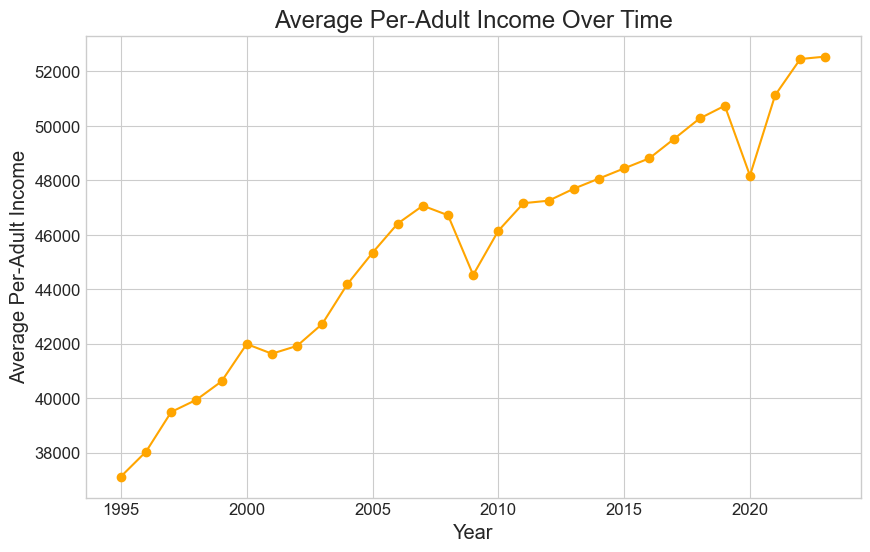

In [52]:

plt.figure(figsize=(10, 6))
plt.plot(avg_income.index, avg_income.values, marker='o', color='orange')
plt.xlabel("Year")
plt.ylabel("Average Per-Adult Income")
plt.title("Average Per-Adult Income Over Time")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import ipywidgets as widgets
from ipywidgets import interact

# Define a function that plots the relationship for a selected year
def plot_year(year):
    # Filter the merged dataframe for the selected year.
    df_year = df_merged[df_merged['Year'] == year].copy()
    
    if df_year.empty:
        print(f"No data available for year {year}.")
        return
        
    # Scale the 'Population' column to determine dot sizes.
    population = df_year['Population']
    marker_sizes = (population / population.max()) * 300  # adjust scaling factor as needed
    
    # Create a new figure for the plot.
    plt.figure(figsize=(10, 6))
    
    # Create a bubble (scatter) plot
    plt.scatter(df_year['PerAdultIncome'], df_year['IncomeInequality'],
                s=marker_sizes, alpha=0.7, edgecolor='k', label='Data Points')
    
    # Compute the regression line if more than one point exists
    x = df_year['PerAdultIncome']
    y = df_year['IncomeInequality']
    if len(x) > 1:
        sorted_idx = np.argsort(x)
        x_sorted = x.iloc[sorted_idx]
        # Fit a line using np.polyfit
        m, b = np.polyfit(x, y, 1)
        y_fit = m * x_sorted + b
        plt.plot(x_sorted, y_fit, color='red', linewidth=2, label='Best Fit Line')
        # Calculate Pearson correlation coefficient
        corr_h1 = x.corr(y)
        annotation_text = f'Pearson Corr: {corr_h1:.2f}'
    else:
        annotation_text = "Not enough data for regression"
    
    # Annotate the plot with the Pearson correlation
    plt.text(0.05, 0.95, annotation_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Set labels and title.
    plt.xlabel(f"Per-Adult National Income ({year})", fontsize=14)
    plt.ylabel(f"Income Inequality ({year})", fontsize=14)
    plt.title(f"Income Inequality vs. Per-Adult Income ({year})", fontsize=16)
    
    # Enhance legend and grid appearance.
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print the Pearson correlation.
    if len(x) > 1:
        print(f"Correlation between Per-Adult Income and Income Inequality in {year}: {corr_h1}")
    else:
        print("Not enough data points to compute Pearson correlation.")
    
    # Build and print the OLS regression summary
    X = sm.add_constant(df_year['PerAdultIncome'])
    model_h1 = sm.OLS(df_year['IncomeInequality'], X).fit()
    print(model_h1.summary())

# Create an interactive slider for the year.
# The slider is set from the minimum to maximum year in the merged dataframe.
min_year = int(df_merged['Year'].min())
max_year = int(df_merged['Year'].max())

interact(plot_year, year=widgets.IntSlider(min=min_year, max=max_year, step=1, value=2020, description='Year:',  layout=widgets.Layout(width='600px')));


interactive(children=(IntSlider(value=2020, description='Year:', layout=Layout(width='600px'), max=2023, min=1…

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import ipywidgets as widgets
from ipywidgets import interact

# Function to plot boxplot and OLS for a selected year
def plot_boxplot_ols(year):
    df_year = df_merged[df_merged['Year'] == year].copy()
    
    if df_year.empty:
        print(f"No data available for year {year}.")
        return
    
    # Divide countries into bins based on PerAdultIncome
    df_year['IncomeBin'] = pd.qcut(df_year['PerAdultIncome'], q=3, labels=['Low', 'Medium', 'High'])
    
    # Compute summary stats
    group_summary = df_year.groupby('IncomeBin')['IncomeInequality'].describe()
    print(f"Summary statistics of IncomeInequality by IncomeBin ({year}):")
    print(group_summary)
    
    # Plot boxplot
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    df_year.boxplot(column='IncomeInequality', by='IncomeBin', grid=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    whiskerprops=dict(color='blue'),
                    capprops=dict(color='blue'))
    
    plt.xlabel("Economic Development Level (Per-Adult Income Bin)", fontsize=14)
    plt.ylabel(f"Income Inequality ({year})", fontsize=14)
    plt.title(f"Income Inequality for Countries with Similar Economic Development ({year})")
    plt.suptitle("")  # Remove automatic supertitle
    plt.tight_layout()
    plt.show()
    
    # OLS Regression
    X = sm.add_constant(df_year['PerAdultIncome'])
    model = sm.OLS(df_year['IncomeInequality'], X).fit()
    print(f"\nCross-sectional OLS Regression Results ({year}):")
    print(model.summary())

# Create interactive slider for year selection
min_year = int(df_merged['Year'].min())
max_year = int(df_merged['Year'].max())

interact(plot_boxplot_ols, year=widgets.IntSlider(
    min=min_year, max=max_year, step=1, value=2020, 
    description='Year:', 
    layout=widgets.Layout(width='600px')  # Adjust slider length
));


interactive(children=(IntSlider(value=2020, description='Year:', layout=Layout(width='600px'), max=2023, min=1…